In [1]:
import numpy as np
import pandas as pd
import xgboost as xgb
from data_preprocessing import preprocess_data
from data_preprocessing import remove_correlated_variables
from data_preprocessing import cap_outliers
from data_loading import load_data
from approval_matrix import plot_approval_matrix
from models import cross_val_pr_curve,tune_hyperparameters
from collections import Counter

In [2]:
train_data_path="/Users/heba/Desktop/Erdos/Training Dataset A_R-384891_Candidate Attach #1_PresSE_SRF #1142.csv"
test_data_path="/Users/heba/Desktop/Erdos/Evaluation Dataset B_R-384891_Candidate Attach #2_PresSE_SRF #1142.csv"
train_df, test_df = load_data(train_data_path,test_data_path)
X_train_processed, y_train, X_test_processed, y_test=preprocess_data(train_df, test_df)

/Users/heba/Desktop/data-science-spring-2025/project/NEW/data_preprocessing.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[28. 17. 26. ... 73. 33. 56.]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  df.loc[:, col] = df[col].clip(upper=upper_limit)


In [3]:
# Hyperparameter tuning using GridSearchCV
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1] 
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [scale_pos_weight]
}
best_params=tune_hyperparameters(X_train_processed,y_train,param_grid,xgb.XGBClassifier(eval_metric='logloss')\
                                 ,'average_precision')

print("Best Hyperparameters for XGBoost Regression:", best_params)


Best Hyperparameters for XGBoost Regression: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 300, 'scale_pos_weight': 0.3544383149448345, 'subsample': 0.7}


In [4]:
# Train xgboost Regression model with best hyperparameters
xgb_model = xgb.XGBClassifier(**best_params)
xgb_model.fit(X_train_processed, y_train);

Cross-Validation Precision Scores: [0.93993873 0.94186368 0.94036111]
Mean Precision Score: 0.9407211739048275
Validation Set Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.72      0.70      5654
           1       0.90      0.88      0.89     15952

    accuracy                           0.84     21606
   macro avg       0.79      0.80      0.79     21606
weighted avg       0.84      0.84      0.84     21606



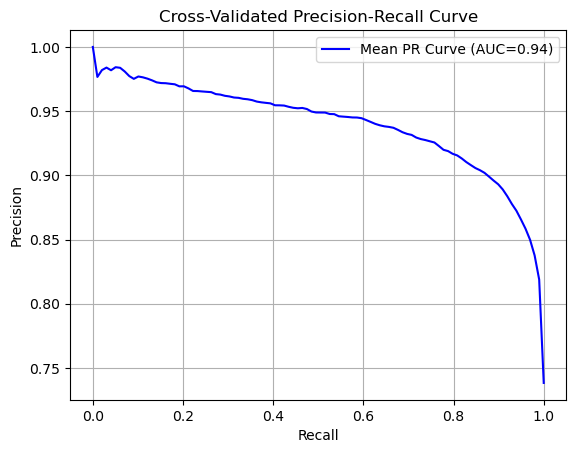

Mean Precision-Recall AUC: 0.9403


In [5]:
from models import evaluate_models
evaluate_models(xgb_model, X_train_processed, y_train,'average_precision')

**Feature Importance Using Permuatiuon**


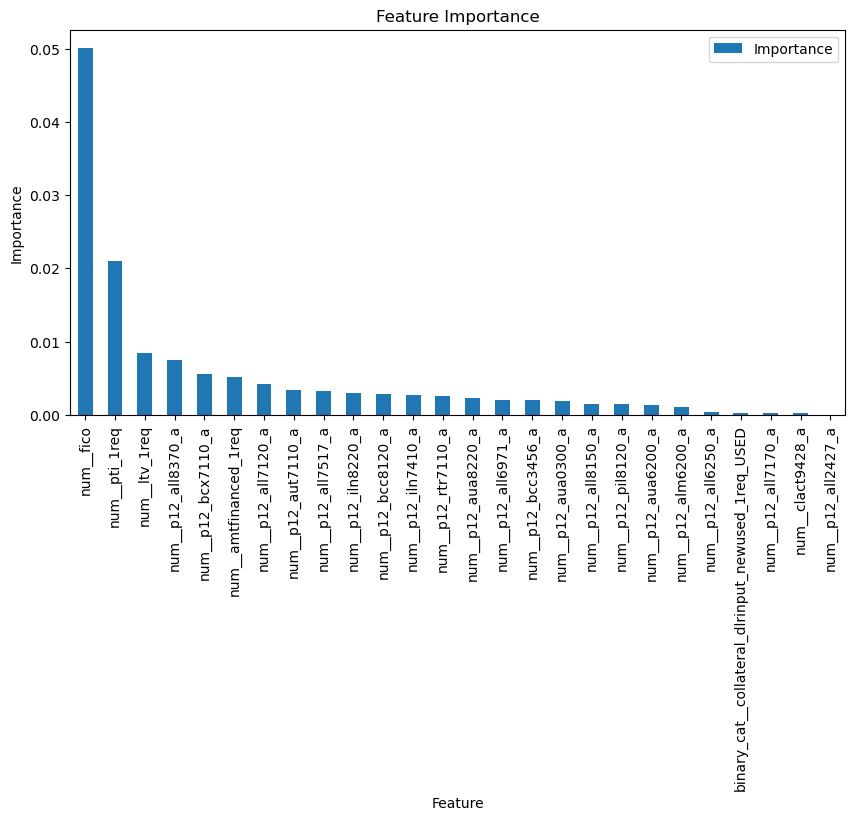

In [6]:
from models import feature_importance
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
feature_importance(xgb_model, X_train_processed, y_train,'average_precision')

In [7]:
y_pred_xgb_test = xgb_model.predict(X_test_processed)

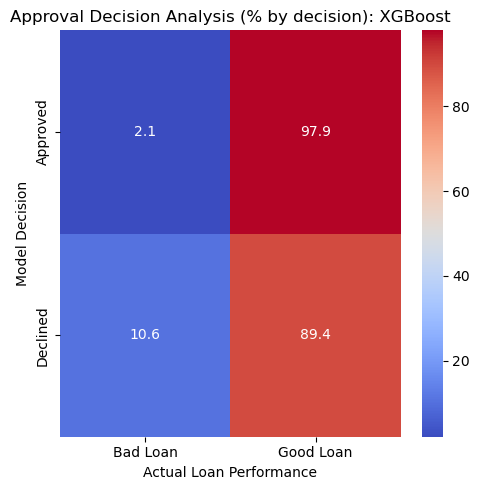

In [8]:
plot_approval_matrix(y_pred_xgb_test,pd.read_csv(test_data_path)['bad_flag'], 'XGBoost')

In [9]:
print("XGBoost model approval rate: ", y_pred_xgb_test.mean())

XGBoost model approval rate:  0.7046296296296296


In [10]:
gender_aprv = pd.DataFrame({'Gender': pd.read_csv(test_data_path)['Gender'], 'Model_Aprv': y_pred_xgb_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
gender_aprv.groupby(['Gender']).mean()

,Model_Aprv,True_Aprv
Gender,,
Female,0.704586,0.737654
Male,0.708667,0.749739
Undefined,0.660232,0.683398


In [11]:
race_aprv = pd.DataFrame({'Race': pd.read_csv(test_data_path)['Race'], 'Model_Aprv': y_pred_xgb_test, 'True_Aprv': pd.read_csv(test_data_path)['aprv_flag']})
race_aprv.groupby(['Race']).mean()

,Model_Aprv,True_Aprv
Race,,
Asian,0.762590,0.755396
Black,0.697260,0.724658
Hispanic,0.672104,0.721044
Other,0.662198,0.718499
White,0.722715,0.756480
